In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import splitfolders
import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dropout, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint


In [7]:

# Split dataset (if not already done)
train_src =r'E:\sanju\asl_alphabet_train\asl_alphabet_train'
splitfolders.ratio(train_src, output="datasets/asl_alphabets", seed=1337, ratio=(.8, .1, .1), move=False)

Copying files: 87000 files [02:43, 532.89 files/s]


In [9]:


# Paths
train_dir = r'E:\sanju\datasets\asl_alphabets\train'
val_dir   = r'E:\sanju\datasets\asl_alphabets\val'
test_dir  = r'E:\sanju\datasets\asl_alphabets\test'
input_shape = (32, 32, 1)
batch_size = 32

# Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Data Generators
train_generator = train_datagen.flow_from_directory(
    train_dir, target_size=input_shape[:2], batch_size=batch_size,
    color_mode="grayscale", class_mode="categorical", shuffle=True
)
val_generator = val_datagen.flow_from_directory(
    val_dir, target_size=input_shape[:2], batch_size=batch_size,
    color_mode="grayscale", class_mode="categorical", shuffle=False
)
test_generator = test_datagen.flow_from_directory(
    test_dir, target_size=input_shape[:2], batch_size=batch_size,
    color_mode="grayscale", class_mode="categorical", shuffle=False
)

# Labels
labels = list(train_generator.class_indices.keys())
num_classes = len(labels)





Found 69600 images belonging to 29 classes.
Found 8700 images belonging to 29 classes.
Found 8700 images belonging to 29 classes.


In [10]:
# 🔨 CNN Architecture (Improved)
model = models.Sequential([
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.3),

    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.4),

    Flatten(),
    Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

c:\Users\ramch\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [11]:

model.summary()



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 29)             │         3,741 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 359,581 (1.37 MB)

 Trainable params: 359,133 (1.37 MB)

 Non-trainable params: 448 (1.75 KB)

In [12]:
# Compile
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
checkpoint = ModelCheckpoint("best_model.keras", monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.5, verbose=1)



In [13]:
# Train
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,
    callbacks=[checkpoint, early_stop, reduce_lr]
)


c:\Users\ramch\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.0709 - loss: 3.4843
Epoch 1: val_accuracy improved from -inf to 0.15195, saving model to best_model.keras
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 221s 100ms/step - accuracy: 0.0709 - loss: 3.4842 - val_accuracy: 0.1520 - val_loss: 3.2187 - learning_rate: 0.0010
Epoch 2/30
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.1952 - loss: 2.7489
Epoch 2: val_accuracy improved from 0.15195 to 0.40287, saving model to best_model.keras
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 173s 80ms/step - accuracy: 0.1952 - loss: 2.7488 - val_accuracy: 0.4029 - val_loss: 2.0137 - learning_rate: 0.0010
Epoch 3/30
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.2883 - loss: 2.4167
Epoch 3: val_accuracy did not improve from 0.40287
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 241s 111ms/step - accuracy: 0.2883 - loss: 2.4167 - val_accuracy: 0.3061 - val_loss: 2.4638 - learning_rate: 0.0010
Epoch 4/30
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy:

In [14]:
model.evaluate(test_generator)

c:\Users\ramch\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


272/272 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - accuracy: 0.9185 - loss: 0.4059


[0.41266322135925293, 0.9132183790206909]

In [35]:
from tensorflow.keras.preprocessing import image
def preprocess_image(img_path):
    """
    Load and preprocess the image to match model input
    """
    img = image.load_img(img_path, color_mode='grayscale', target_size=(32, 32))
    img_array = image.img_to_array(img) / 255.0  # Normalize
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    return img_array

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
Predicted: F (87.28%)


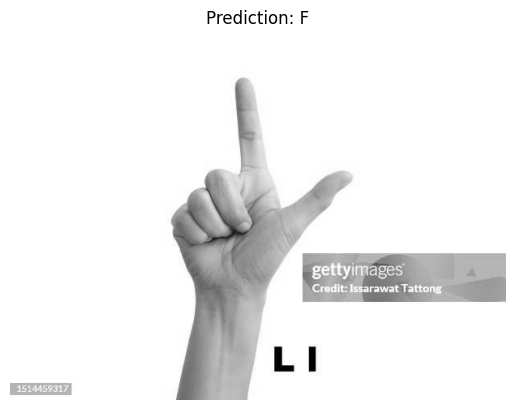

In [41]:
class_labels = list(train_generator.class_indices.keys())
def predict_asl(img_path):
    """
    Predict the ASL class for a given image path
    """
    img_array = preprocess_image(img_path)
    prediction = model.predict(img_array)
    class_index = np.argmax(prediction)
    predicted_label = class_labels[class_index]
    confidence = np.max(prediction)

    print(f"Predicted: {predicted_label} ({confidence*100:.2f}%)")

    # Show the image
    plt.imshow(image.load_img(img_path, color_mode='grayscale'), cmap='gray')
    plt.axis('off')
    plt.title(f"Prediction: {predicted_label}")
    plt.show()

# Example usage
predict_asl(r"C:\Users\ramch\Downloads\LL.jpg")

In [39]:

# Save final model
model.save("asl_alphabet_final_model.keras")